## Assignment 1 - Machine Learning Project
### Project 1: Classify Images of Colon Cancer
##### Group No. 3: Sheikh Abdul Munim (s4076159), Liya Benoy (s4027344)

In [11]:
#importing required libraries
import pandas as pd

import os
from PIL import Image
import matplotlib.pyplot as plt
from collections import OrderedDict, defaultdict
import numpy as np

In [12]:
main_data = pd.read_csv("Image_classification_data\data_labels_mainData.csv")
main_data.head()

,InstanceID,patientID,ImageName,cellTypeName,cellType,isCancerous
0,22405,1,22405.png,fibroblast,0,0
1,22406,1,22406.png,fibroblast,0,0
2,22407,1,22407.png,fibroblast,0,0
3,22408,1,22408.png,fibroblast,0,0
4,22409,1,22409.png,fibroblast,0,0


In [13]:
class ColonCancerPatchServer:
    def __init__(self, main_data_path, extra_data_path, image_folder):
        self.main_df = pd.read_csv(main_data_path)
        self.extra_df = pd.read_csv(extra_data_path)
        self.image_folder = image_folder

        # Merge both datasets and track source
        self.main_df["source"] = "main"
        self.extra_df["source"] = "extra"
        self.data = pd.concat([self.main_df, self.extra_df], ignore_index=True)
        self.data["ImagePath"] = self.data["ImageName"].apply(lambda x: os.path.join(image_folder, x))

    def __len__(self):
        return len(self.data)

    def get_image(self, idx, target_size=(27, 27), normalize=True):
        image_path = self.data.iloc[idx]["ImagePath"]
        try:
            img = Image.open(image_path).convert("RGB").resize(target_size)
            img_array = np.array(img)
            if normalize:
                img_array = img_array / 255.0
            return img_array
        except Exception as e:
            print(f"Error loading image {image_path}: {e}")
            return None

    def get_labels(self, idx):
        row = self.data.iloc[idx]
        is_cancerous = int(row["isCancerous"])
        cell_type = row.get("cellTypeName", None)
        return is_cancerous, cell_type

    def get_sample(self, idx, target_size=(27, 27), normalize=True):
        image = self.get_image(idx, target_size, normalize)
        is_cancerous, cell_type = self.get_labels(idx)
        return image, is_cancerous, cell_type

    def get_data_split(self, label_type="isCancerous"):
        """
        Get data suitable for training/testing
        label_type: "isCancerous" or "cellTypeName"
        """
        X, y = [], []
        for idx in range(len(self.data)):
            image = self.get_image(idx)
            label = self.data.iloc[idx][label_type]
            if pd.isna(label) or image is None:
                continue
            X.append(image)
            y.append(label)
        return np.array(X), np.array(y)

In [16]:
# Initialize server
server = ColonCancerPatchServer(
    main_data_path="Image_classification_data\data_labels_mainData.csv",
    extra_data_path="Image_classification_data\data_labels_extraData.csv",
    image_folder="Image_classification_data\patch_images"
)

# Get a single sample
img, cancer_label, cell_type = server.get_sample(0)
print(img.shape, cancer_label, cell_type)

(27, 27, 3) 0 fibroblast


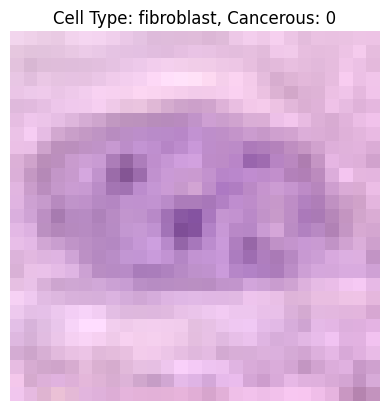

In [17]:
# Load sample image from index 0
image, is_cancerous, cell_type = server.get_sample(0)

# Plot the image
plt.imshow(image)
plt.title(f"Cell Type: {cell_type}, Cancerous: {is_cancerous}")
plt.axis("off")
plt.show()